In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import multiprocessing
import random
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 50
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=5.0
plt.rcParams['figure.figsize'] = 30,30  #width,height
plt.rcParams['lines.markersize']=40
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=50
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=5.0

plt.rcParams['ytick.major.size']=35
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=5.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'


# Function to calculate the center of mass (CM)
def calculate_cm(positions, masses):
    total_mass = np.sum(masses)
    cm = np.sum(positions * masses[:, None], axis=0) / total_mass
    return cm

# Function to calculate the torque for each atom and the total torque about the center of mass (CM)
def calculate_total_torque(positions, forces, cm):
    torques = []
    total_torque = np.zeros(3)  # Initialize the total torque as a zero vector
    # Calculate the torque for each atom
    for i in range(len(positions)):
        r, f = positions[i] - cm, forces[i]  # Position relative to the center of mass # Force on the atom
        torque = np.cross(r, f) # Torque is the cross product of position and force vectors
        torques.append(torque)
        total_torque += torque  # Sum up the torques to get the net torque
    return np.array(torques), total_torque

def get_box(filename):
    positions = []
    forces = []
    masses = []

    with open(filename, 'r') as f:
        for _ in range(5):
            next(f)
        box_size_line = f.readline().strip()
        box_size = np.array(list(map(float, box_size_line.split())))[1]
    return box_size

# Function to load the data from the file
def load_data(filename, center_xy, center_z,sph_rad):
    positions, forces, masses = [], [], []

    with open(filename, 'r') as f:
        for _ in range(5):
            next(f)
        box_size_line = f.readline().strip()
        box_size = np.array(list(map(float, box_size_line.split())))[1]
        for _ in range(4):
            next(f)
        data = []
        for line in f:
            data.append(line.split()[1:])
        # Create a DataFrame with columns ["Type", "x", "y", "z", "fx", "fy", "fz"]
        df = pd.DataFrame(data, columns=["Type", "x", "y", "z", "fx", "fy", "fz"])
        df = df.astype({"Type": int, "x": float, "y": float, "z": float, "fx": float, "fy": float, "fz": float})
        distances = np.sqrt((df["x"] - center_xy[0])**2 + \
                            (df["y"] - center_xy[1])**2 + \
                            (df["z"] - (box_size*0.5+center_z))**2)
        df_filtered = df[distances <= sph_rad].copy()

        # Assign masses based on the "Type" column
        mass_map = {1: 6.941, 2: 92.90638, 3: 16.0}
        df_filtered["mass"] = df_filtered["Type"].map(mass_map)
        # Extract positions, forces, and masses for the filtered atoms
        positions = df_filtered[["x", "y", "z"]].values
        forces = df_filtered[["fx", "fy", "fz"]].values
        masses = df_filtered["mass"].values
    return positions, forces, masses, df_filtered, box_size

# Define the function that will be parallelized
def calculate_torque_for_center(center, z_center, filename, sph_rad):
    positions, forces, masses, filtered_df, box_size = load_data(filename, center, z_center, sph_rad)
    cm = calculate_cm(positions, masses)
    torques, total_torque = calculate_total_torque(positions, forces, cm)
    return np.linalg.norm(total_torque)

# Reload and plot function
def reload_and_plot(filename="torque_magnitudes.pkl"):
    with open(filename, "rb") as f:
        all_torque_mags, X, Y = pickle.load(f)
    plot_results_3d_mesh(all_torque_mags, X, Y)

All the models have the same box size.
Box Size: 181.7376018642


Processing model VI: 100%|██████████| 10/10 [13:49<00:00, 82.98s/it]


Averaged results saved to torque_magnitudes_average.pkl


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


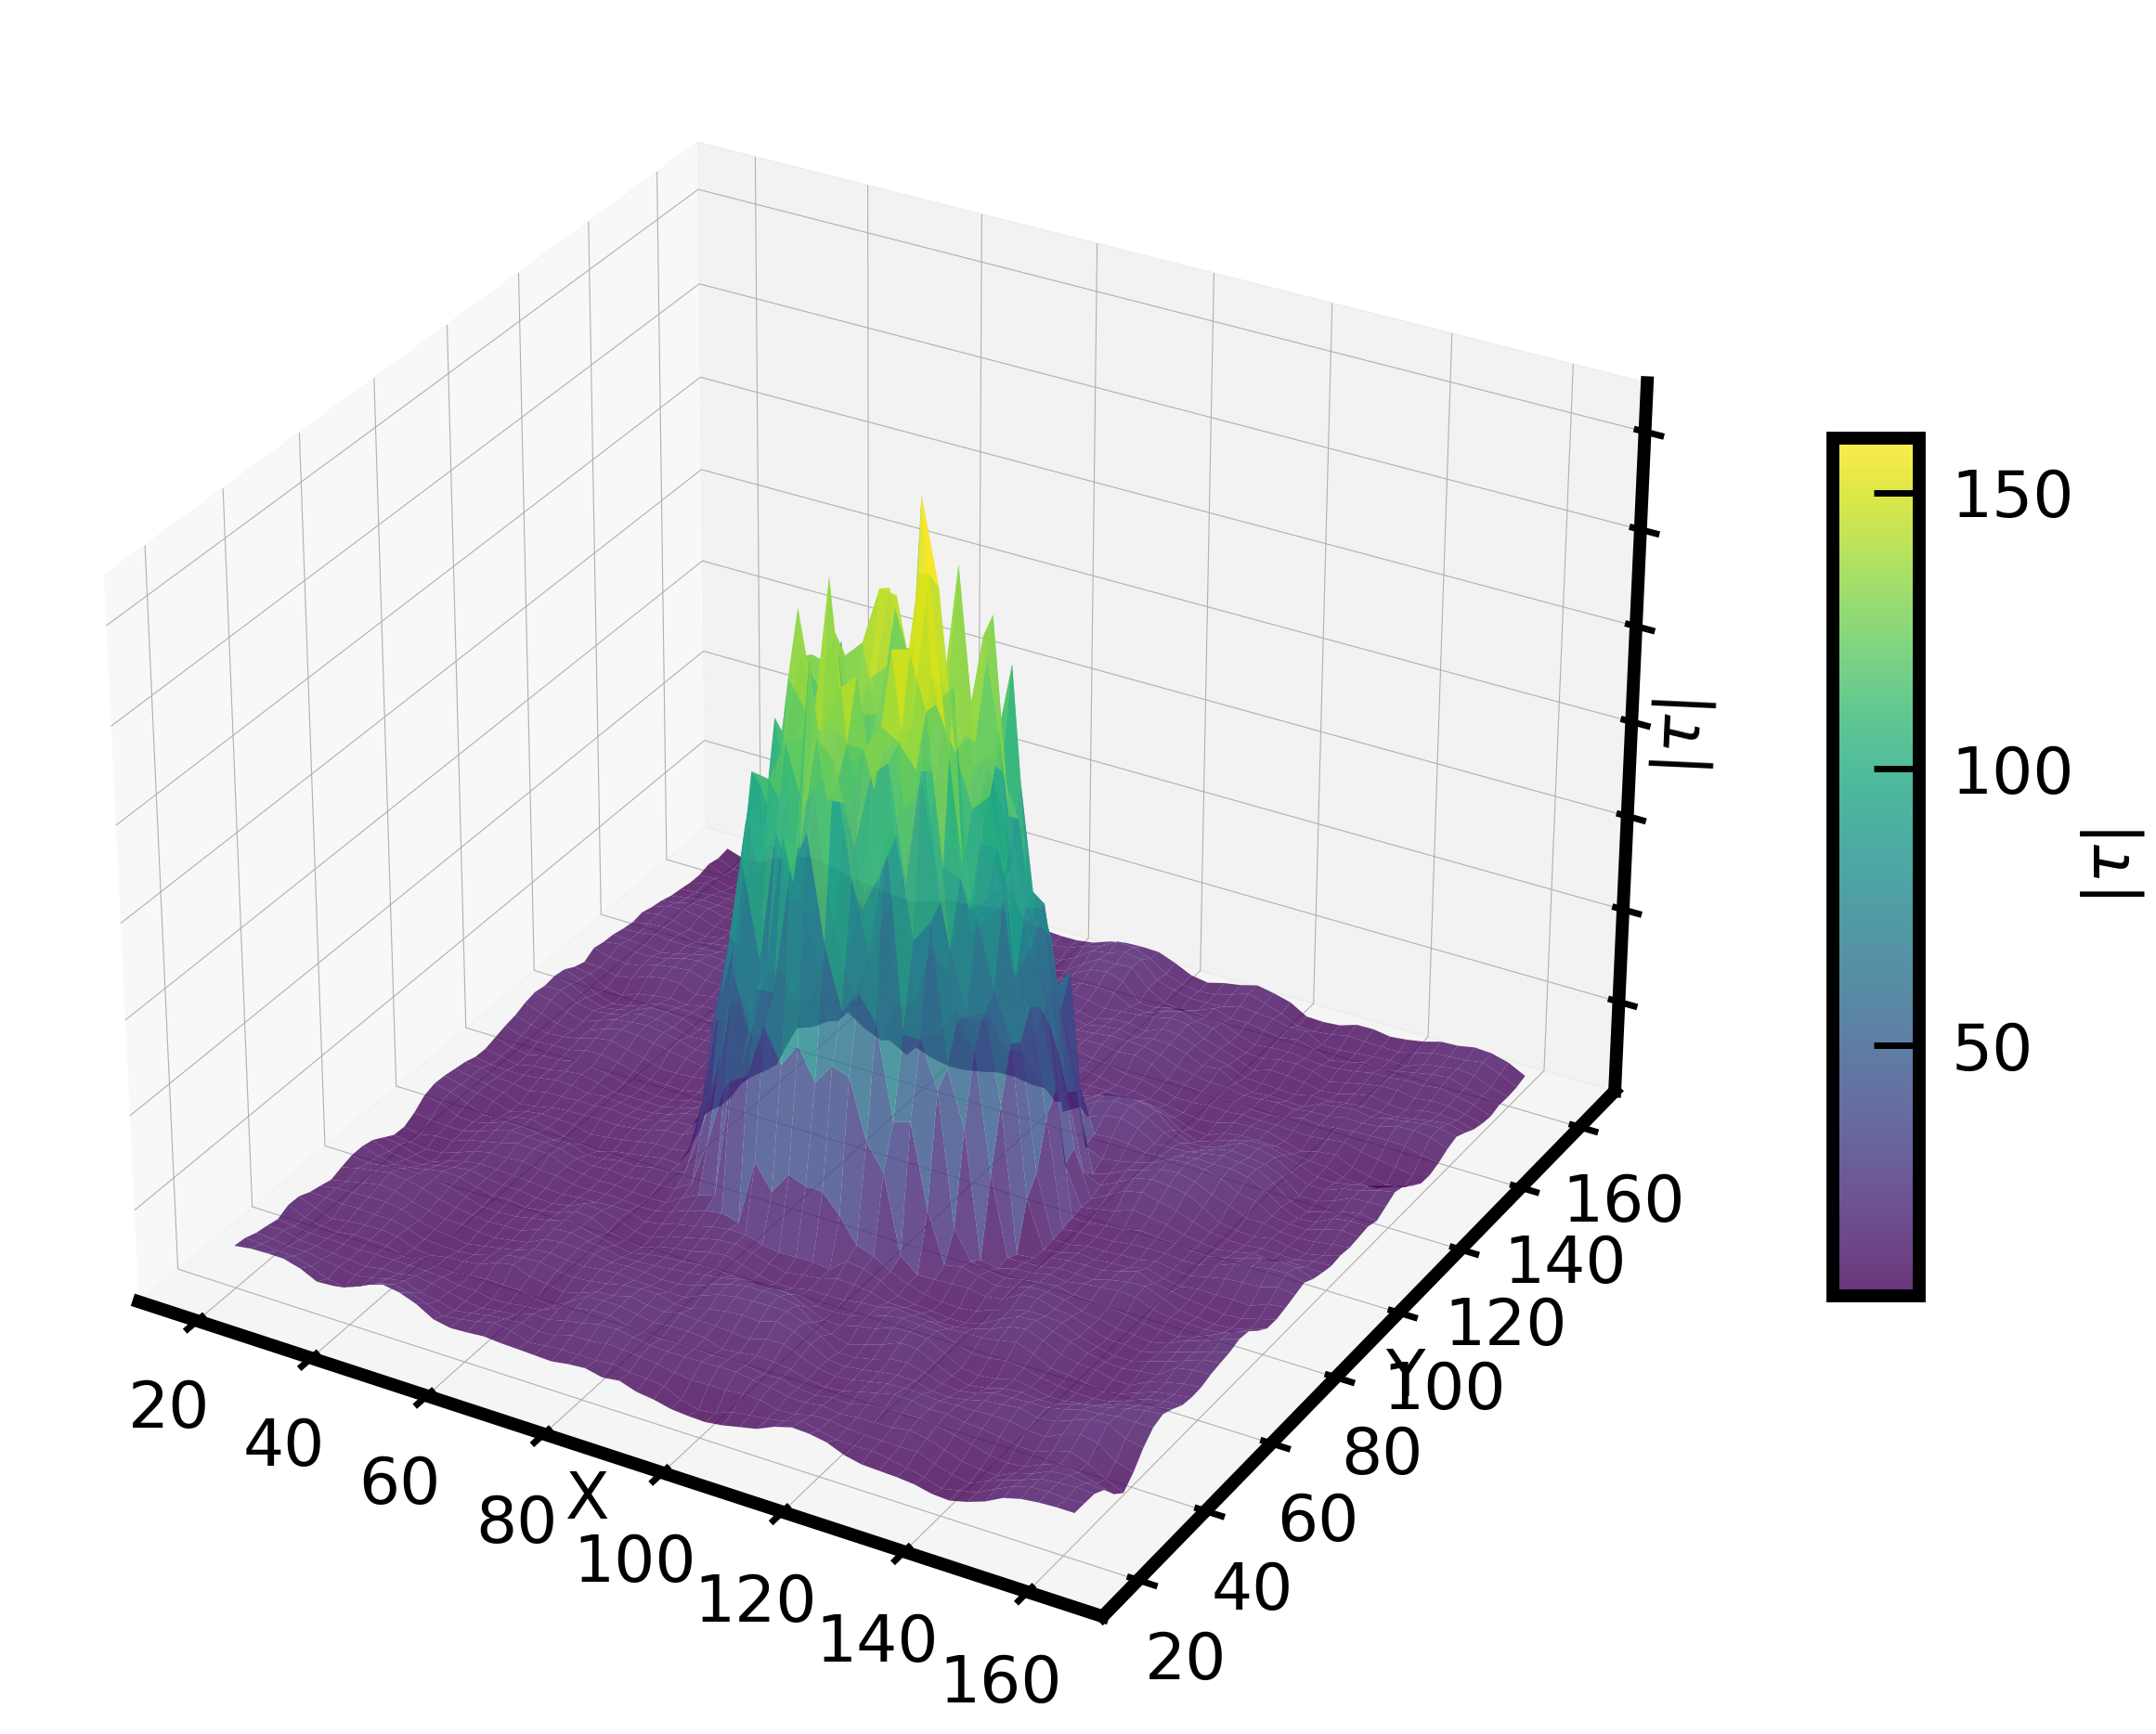

In [2]:
import numpy as np
import multiprocessing
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Existing functions remain unchanged...

def main():
    box = []
    models = ["VI"]  # Add more models as needed
    for run in models:  # Run it over all models
        filename = f'forces_{run}.dump'
        box.append(get_box(filename))

    if all(element == box[0] for element in box):
        print("All the models have the same box size.")
        box_size = box[0]
        print(f"Box Size: {box_size}")
        # Radius of the sample spheres chosen for calculating torque
        sph_rad, cut_off, n_bins = 15.0, 5.0, 50
        x_bins = np.linspace(sph_rad+cut_off, box_size-(sph_rad+cut_off), n_bins)
        y_bins = np.linspace(sph_rad+cut_off, box_size-(sph_rad+cut_off), n_bins)
        X, Y = np.meshgrid(x_bins, y_bins)
        # Flatten the meshgrid for processing
        meshgrid_centers = np.vstack([X.ravel(), Y.ravel()]).T

    all_torque_mags = {}  # Dictionary to store torque magnitudes for each model
    for run in models:
        filename = f"forces_{run}.dump"
        # Create 10 evenly spaced points for z_center between -16 and 16
        z_centers = np.linspace(-20, 20, 10)
        
        average_torque_mags = np.zeros(X.shape)  # Initialize the average torque array
        for z_center in tqdm(z_centers, desc=f"Processing model {run}"):
            # Use multiprocessing to parallelize the calculation
            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                torque_mag = pool.starmap(calculate_torque_for_center, [(center, z_center, filename, sph_rad) for center in meshgrid_centers])
            # Accumulate torque magnitudes to compute the average
            average_torque_mags += np.array(torque_mag).reshape(X.shape)
        
        # Compute the average by dividing by the number of z_centers
        average_torque_mags /= len(z_centers)
        all_torque_mags[run] = average_torque_mags

    # Save the averaged results to a file
    with open(f"torque_magnitudes_average_{run}.pkl", "wb") as f:
        pickle.dump((all_torque_mags, X, Y), f)
    print("Averaged results saved to torque_magnitudes_average.pkl")

    # Plot the results
    plot_results_3d_mesh(all_torque_mags, X, Y)

# Updated 3D plot function for meshgrid
def plot_results_3d_mesh(all_torque_mags, X, Y):
    fig = plt.figure(figsize=(30, 24))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis
    
    for model, torque_mag in all_torque_mags.items():
        # Plot the surface
        surf = ax.plot_surface(X, Y, torque_mag, cmap='viridis', alpha=0.8)
        # Add a color bar for torque magnitude
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label=r'$\left | \tau \right |$')

    # Setting labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zticklabels([])
    ax.set_zlabel(r'$\left | \tau \right | $')

    # Add grid and display the plot
    ax.grid(True)
    
    plt.show()
    
if __name__ == '__main__':
    main()


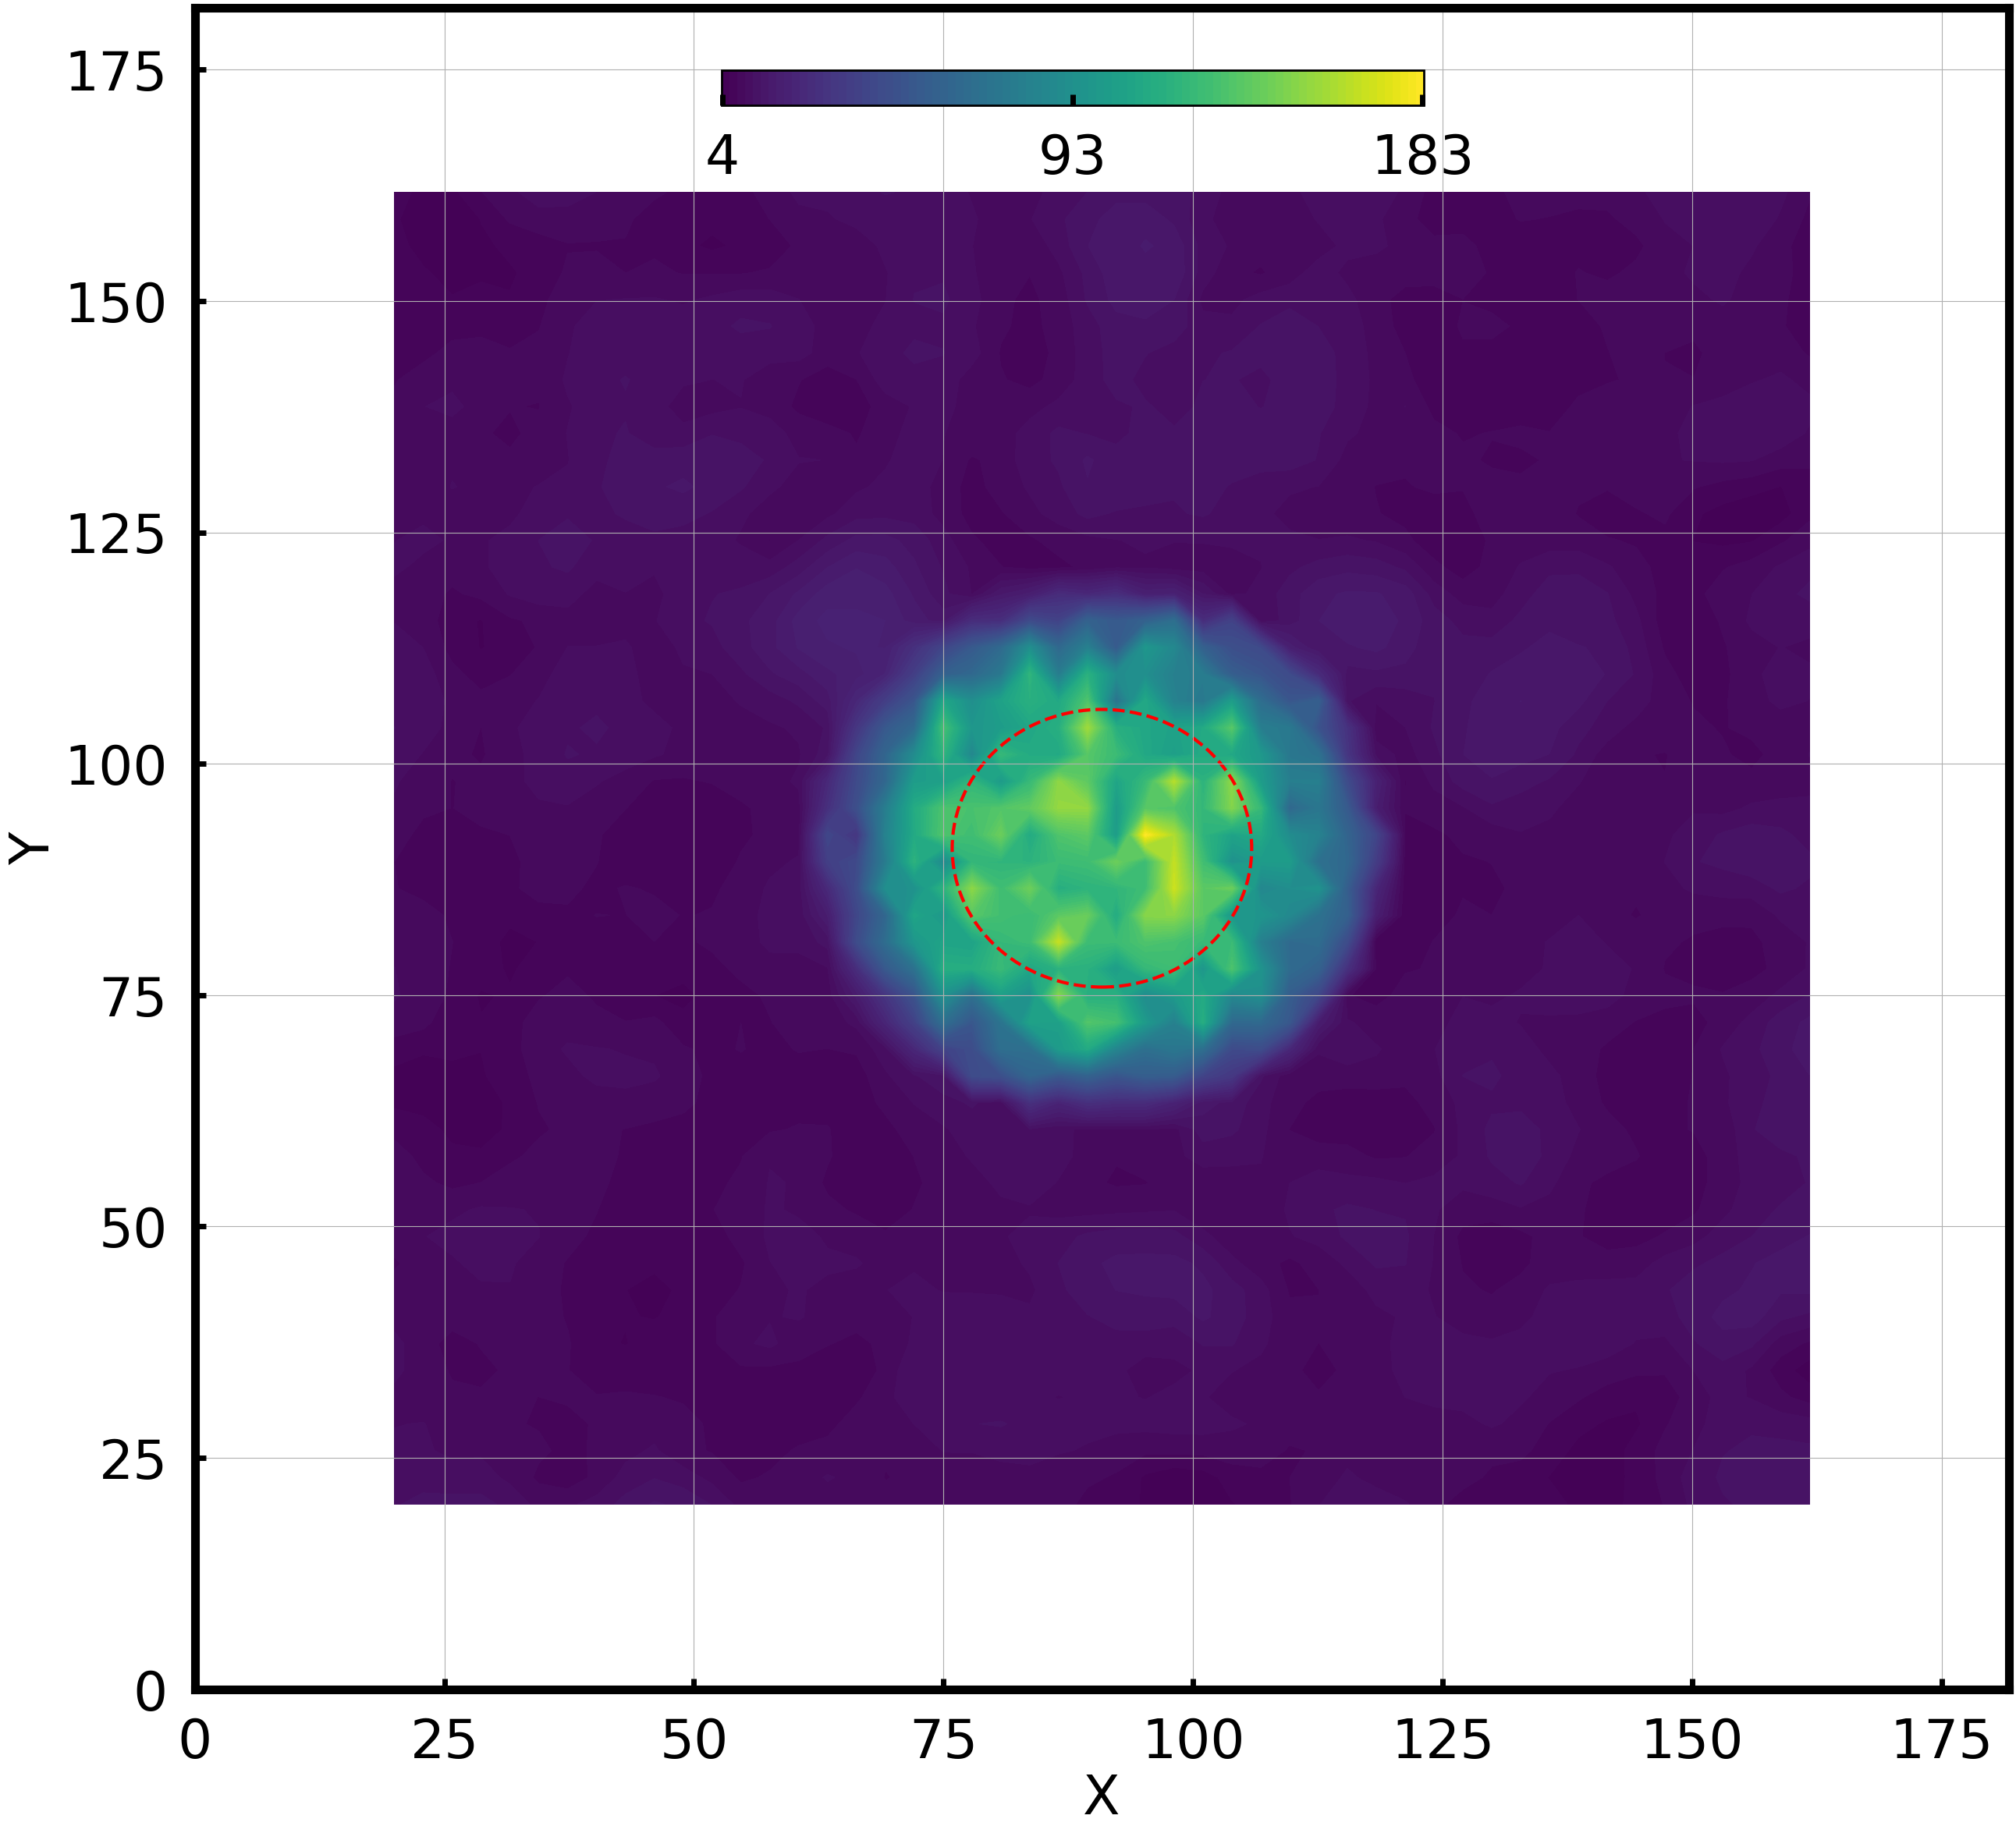

In [3]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 50
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=5.0
plt.rcParams['figure.figsize'] = 30,30  #width,height
plt.rcParams['lines.markersize']=40
plt.rcParams['axes.linewidth'] =8.0

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=5.0

plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=5.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_results_2d_mesh(all_torque_mags_list, X_list, Y_list, vmin, vmax):
    fig, axes = plt.subplots(1, len(all_torque_mags_list), figsize=(30, 40))
    
    if len(all_torque_mags_list) == 1:  # Handle the case of a single plot
        axes = [axes]

    contour_sets = []  # Store contour sets for the color bar
    for i, (ax, all_torque_mags, X, Y) in enumerate(zip(axes, all_torque_mags_list, X_list, Y_list)):
        for model, torque_mag in all_torque_mags.items():
            # Create a 2D contour plot with filled contours
            c = ax.contourf(X, Y, torque_mag, cmap='viridis', levels=100, vmin=vmin, vmax=vmax)
            contour_sets.append(c)  # Keep track of the last contour set

        # Add circles to the plot
        circle1 = patches.Circle((90.87,90.87), 15, color='red', fill=False, linewidth=3, linestyle='--')
        # circle2 = patches.Circle((106.85, 75.85), 15, color='blue', fill=False, linewidth=3, linestyle='--')
        ax.add_patch(circle1)
        # ax.add_patch(circle2)

        # Setting labels
        ax.set_xlabel("X")
        if i == 0:
            ax.set_ylabel("Y")
        else:
            ax.set_yticklabels([])  # Remove y-axis tick labels
            ax.set_ylabel("")       # Remove y-axis label

        ax.set_xlim(0, 181.70)
        ax.set_ylim(0, 181.70)
        ax.grid(True)
    
    # Adjust subplot spacing to reduce the gap
    plt.subplots_adjust(wspace=0.02)

    # Add a single horizontal color bar at the top of the figure
    cbar = fig.colorbar(contour_sets[-1], ax=axes, orientation='horizontal', pad=0.15, aspect=20)
    cbar.ax.set_position([0.35, 0.765, 0.3, 0.095])  # x, y, width, height in figure coordinates
    # cbar.set_label(r'$\left | \tau \right |$')  # Label the color bar
    
    # Set only three ticks (min, mean, max)
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
    cbar.set_ticklabels([f"{int(vmin)}", f"{int((vmin + vmax) / 2)}", f"{int(vmax)}"])  # Custom tick labels
    # Customize the border of the color bar
    cbar.outline.set_visible(True)       # Ensure the border is visible
    cbar.outline.set_linewidth(2.0)     # Set the border width to 2.0

    plt.savefig("VI_torque_averaged.png", bbox_inches="tight")# Display the plot
    plt.show()



def reload_and_plot_2D(filenames):
    all_torque_mags_list = []
    X_list = []
    Y_list = []
    all_torque_values = []

    # Load data from all files
    for filename in filenames:
        with open(filename, "rb") as f:
            all_torque_mags, X, Y = pickle.load(f)
            all_torque_mags_list.append(all_torque_mags)
            X_list.append(X)
            Y_list.append(Y)
            # Gather all torque magnitude values to determine vmin and vmax
            for model, torque_mag in all_torque_mags.items():
                all_torque_values.extend(torque_mag.flatten())
    
    # Determine the global min and max for the color bar
    vmin = np.min(all_torque_values)
    vmax = np.max(all_torque_values)
    # vmin, vmax = 0, 75
    
    # Plot with consistent color scale and a single color bar
    plot_results_2d_mesh(all_torque_mags_list, X_list, Y_list, vmin, vmax)

# Example usage
filenames = [ "torque_magnitudes_average_VI.pkl"]
reload_and_plot_2D(filenames)


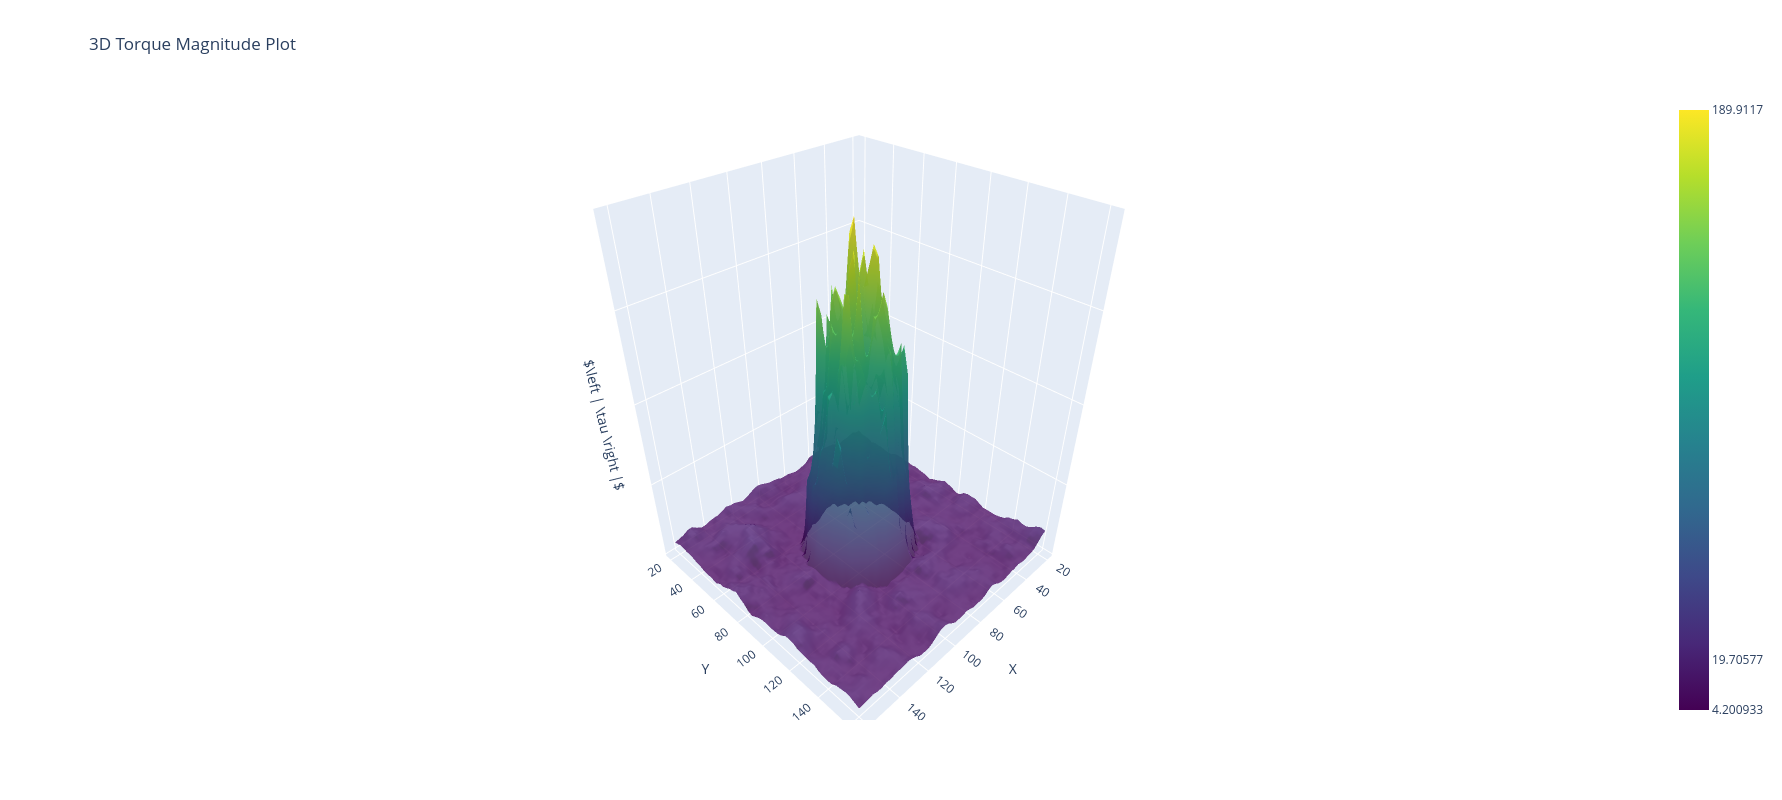

In [7]:
import pickle
import plotly.graph_objects as go
import numpy as np

# Function to load the .pkl file
def load_pkl_file(filename):
    with open(filename, 'rb') as f:
        all_torque_mags, X, Y = pickle.load(f)
    return all_torque_mags, X, Y

# Function to plot the loaded data as an interactive 3D plot
def plot_results_3d_mesh(all_torque_mags, X, Y):
    # Create a 3D plot using plotly
    fig = go.Figure()

    # Loop through the models and add a surface for each model
    for model, torque_mag in all_torque_mags.items():
        # Add surface plot for each model's torque magnitude
        fig.add_trace(go.Surface(
            x=X, y=Y, z=torque_mag, 
            colorscale='Viridis', 
            colorbar=dict(title=r'$\left | \tau \right |$', tickvals=[np.min(torque_mag), np.mean(torque_mag), np.max(torque_mag)]),
            opacity=0.8
        ))

    # Set the axis labels
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title=r'$\left | \tau \right |$',
            zaxis=dict(showticklabels=False),  # Hide z-tick labels
        ),
        title="3D Torque Magnitude Plot",
        height=800,
        width=1000
    )

    # Show the plot
    fig.show()

# Load the .pkl file and plot the data
filename = "torque_magnitudes_average_VI.pkl"  # Update with your actual file name
all_torque_mags, X, Y = load_pkl_file(filename)

# Plot the results interactively
plot_results_3d_mesh(all_torque_mags, X, Y)


In [4]:
import pickle
import plotly.graph_objects as go
import numpy as np
import os
import shutil

# Function to load the .pkl file
def load_pkl_file(filename):
    with open(filename, 'rb') as f:
        all_torque_mags, X, Y = pickle.load(f)
    return all_torque_mags, X, Y

# Function to plot and save frames as images
def save_rotation_frames(all_torque_mags, X, Y, output_folder='rotation_frames', duration=10, frame_rate=30):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)  # Remove the folder if it exists
    os.makedirs(output_folder)  # Create the output folder for frames

    # Set up Plotly figure
    fig = go.Figure()

    # Loop through the models and add a surface for each model
    for model, torque_mag in all_torque_mags.items():
        fig.add_trace(go.Surface(
            x=X, y=Y, z=torque_mag,
            colorscale='Viridis',
            colorbar=dict(title=r'$\left | \tau \right |$', tickvals=[np.min(torque_mag), np.mean(torque_mag), np.max(torque_mag)]),
            opacity=0.8
        ))

    # Set the axis labels and initial layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title=r'$\left | \tau \right |$',
            zaxis=dict(showticklabels=False),  # Hide z-tick labels
        ),
        title="3D Torque Magnitude Plot",
        height=800,
        width=1000
    )

    # Get the number of frames
    num_frames = duration * frame_rate
    for frame in range(num_frames):
        # Rotate the camera by adjusting the azimuth angle
        fig.update_layout(
            scene_camera=dict(
                eye=dict(x=2.5 * np.cos(frame * 2 * np.pi / num_frames),
                         y=2.5 * np.sin(frame * 2 * np.pi / num_frames),
                         z=0.5)
            )
        )

        # Save the current frame as an image
        fig.write_image(f"{output_folder}/frame_{frame:03d}.png")

# Function to create a video from saved frames using ffmpeg
def create_video_from_frames(frame_folder='rotation_frames', output_video='rotation_movie_VI.mp4', frame_rate=30, duration=10):
    # Ensure ffmpeg is installed and accessible in the system's PATH
    os.system(f"ffmpeg -framerate {frame_rate} -i {frame_folder}/frame_%03d.png -r {frame_rate} -pix_fmt yuv420p {output_video}")

    # Optionally, clean up the frames after video creation
    shutil.rmtree(frame_folder)

# Main function to load data, save frames, and create video
def main():
    filename = "torque_magnitudes_average_VI.pkl"  # Update with your actual file name
    all_torque_mags, X, Y = load_pkl_file(filename)

    # Save frames of the rotating plot
    save_rotation_frames(all_torque_mags, X, Y)

    # Create video from the saved frames
    create_video_from_frames()

if __name__ == "__main__":
    main()


ffmpeg version 7.0.1-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   

In [5]:
print("DONE")

DONE
